In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import multiprocessing
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
from spectral import *
from functions import *
import warnings
import time

In [ ]:
def task(r):
    np.random.seed(r)
    Y = np.zeros([m,n])
    for i in range(p):
        Y[i,:] = 1*np.random.randn(n) + i
    for i in range(q):
        Y[:,i] = 1*np.random.randn(m) + i

    for i in range(p,m):
        for j in range(q,n):
            Y[i,j] = np.sum(Y[(i-p):(i+1),(j-q):(j+1)] * beta) + 0.1 * np.sum(np.random.randn(1))
            
            ### Change Y here for non-zero trend
            #Y[i,j] = np.sum(Y[(i-p):(i+1),(j-q):(j+1)] * beta) + 0.1 * np.sum(np.random.randn(1)) + 0.01 *(i-j)

    cov_loc = causal_get_cov_loc(order)

    start_XX = time.time()
    XX = np.zeros([(m-p), (n-q),len(cov_loc)])
    i = 0
    for loc in cov_loc:
        k = loc[0]
        l = loc[1]
        XX[:,:,i] = Y[(p+k):(m+k), (q+l):(n+l)]
        i = i + 1
    end_XX = time.time()
    time_XX[r] = end_XX - start_XX

    start_lev = time.time()
    MSE_temp = np.ones(len(cov_loc))
    for l in range(len(cov_loc)-1, len(cov_loc)):
    #for l in range(len(cov_loc)):
        XX_temp = XX[:,:,:(l+1)]
        lev_temp = np.zeros([m-p,n-q])
        matrix_inv = np.linalg.inv(tensor_multiply(XX_temp, XX_temp))
        for i in range(m-p):
            for j in range(n-q):
                lev_temp[i,j] = XX_temp[i,j,:].T @ matrix_inv @ XX_temp[i,j,:]
        phi_lev = two_dim_param_estimate_leverage(XX_temp, Y[p:,q:], lev_score = lev_temp, subsample_size = subsample_size)
        MSE_temp[l] = MSE_calculate(XX_temp, Y[p:,q:], phi_lev)
    end_lev = time.time()
    time_lev = end_lev - start_lev
    MSE_lev = np.min(MSE_temp)
    MSE_para_lev = np.mean((phi - phi_lev)**2)

    start_fast = time.time()
    leverage_score = causal_fast_2d_AR_leverage_score(Y, order=order, subsample_size = subsample_size)
    phi_fast = two_dim_param_estimate_leverage(XX, Y[p:,q:], lev_score = leverage_score[p:,q:], subsample_size = subsample_size)
    end_fast = time.time()
    time_fast = end_fast - start_fast
    MSE_fast = MSE_calculate(XX, Y[p:,q:], phi_fast)
    MSE_para_fast = np.mean((phi - phi_fast)**2)

    start_OLS = time.time()
    MSE_temp = np.ones(len(cov_loc))
    for l in range(len(cov_loc)-1, len(cov_loc)):
    #for l in range(len(cov_loc)):
        XX_temp = XX[:,:,:(l+1)]
        phi_OLS = two_dim_param_estimate_leverage(XX_temp, Y[p:,q:]).reshape(-1)
        MSE_temp[l] = MSE_calculate(XX_temp, Y[p:,q:], phi_OLS)
    end_OLS = time.time()
    time_OLS = end_OLS - start_OLS
    MSE_OLS = np.min(MSE_temp)
    MSE_para_OLS = np.mean((phi - phi_OLS)**2)

    start_random = time.time()
    MSE_temp = np.ones(len(cov_loc))
    for l in range(len(cov_loc)-1, len(cov_loc)):
    #for l in range(len(cov_loc)):
        XX_temp = XX[:,:,:(l+1)]
        phi_random = two_dim_param_estimate_leverage(XX, Y[p:,q:], lev_score = np.ones([m-p,n-q]), subsample_size = subsample_size)
        MSE_temp[l] = MSE_calculate(XX_temp, Y[p:,q:], phi_random)
    end_random = time.time()
    time_random = end_random - start_random
    MSE_random = np.min(MSE_temp)
    MSE_para_random = np.mean((phi - phi_random)**2)

    return MSE_lev, MSE_fast, MSE_OLS, MSE_random, time_lev, time_fast, time_OLS, time_random, MSE_para_lev, MSE_para_fast, MSE_para_OLS, MSE_para_random

In [ ]:
order_list = [[1,1]]
#order_list = [250, 500, 1000, 2000, 4000, 8000]
nrep = 100
SEED = 2024
subsample_size = 1000
#np.random.seed(SEED)

MSE_lev_list = np.zeros(len(order_list))
MSE_fast_list = np.zeros(len(order_list))
MSE_OLS_list = np.zeros(len(order_list))
MSE_random_list = np.zeros(len(order_list))
MSE_para_lev_list = np.zeros(len(order_list))
MSE_para_fast_list = np.zeros(len(order_list))
MSE_para_OLS_list = np.zeros(len(order_list))
MSE_para_random_list = np.zeros(len(order_list))
time_lev_list = np.zeros(len(order_list))
time_fast_list = np.zeros(len(order_list))
time_fast_trick_list = np.zeros(len(order_list))
time_OLS_list = np.zeros(len(order_list))
time_random_list = np.zeros(len(order_list))
time_XX_list = np.zeros(len(order_list))

MSE_lev_std_list = np.zeros(len(order_list))
MSE_fast_std_list = np.zeros(len(order_list))
MSE_OLS_std_list = np.zeros(len(order_list))
MSE_random_std_list = np.zeros(len(order_list))
MSE_para_lev_std_list = np.zeros(len(order_list))
MSE_para_fast_std_list = np.zeros(len(order_list))
MSE_para_OLS_std_list = np.zeros(len(order_list))
MSE_para_random_std_list = np.zeros(len(order_list))
time_lev_std_list = np.zeros(len(order_list))
time_fast_std_list = np.zeros(len(order_list))
time_fast_trick_std_list = np.zeros(len(order_list))
time_OLS_std_list = np.zeros(len(order_list))
time_random_std_list = np.zeros(len(order_list))

MSE_lev = np.zeros(nrep)
MSE_fast = np.zeros(nrep)
MSE_OLS = np.zeros(nrep)
MSE_random = np.zeros(nrep)
time_lev = np.zeros(nrep)
time_fast = np.zeros(nrep)
time_fast_trick = np.zeros(nrep)
time_OLS = np.zeros(nrep)
time_random = np.zeros(nrep)
time_XX = np.zeros(nrep)

m = 300
n = 100

order_num = 0
para_num_list = []

for order in order_list:
    p = order[0]
    q = order[1]
    beta = beta_generate(order, method = '3')    ### Change the beta for unstationary case
    #beta[0,0] = -0.9
    #beta[0,1] = 1
    #beta[1,0] = 0.9
    phi = beta.reshape(-1)[0:(p*q+p+q)]
    para_num = (p+1)*(q+1)-1
    para_num_list.append(para_num)
    print(order)
    with multiprocessing.Pool(processes = 20) as pool:
        results = pool.map(task, range(nrep))
        A = np.array(results)
        MSE_lev = A[:,0]
        MSE_fast = A[:,1]
        MSE_OLS = A[:,2]
        MSE_random = A[:,3]
        time_lev = A[:,4]
        time_fast = A[:,5]
        time_OLS = A[:,6]
        time_random = A[:,7]
        MSE_para_lev = A[:,8]
        MSE_para_fast = A[:,9]
        MSE_para_OLS = A[:,10]
        MSE_para_random = A[:,11]

    MSE_lev_list[order_num] = np.mean(MSE_lev)
    MSE_fast_list[order_num] = np.mean(MSE_fast)
    MSE_OLS_list[order_num] = np.mean(MSE_OLS)
    MSE_random_list[order_num] = np.mean(MSE_random)
    MSE_para_lev_list[order_num] = np.mean(MSE_para_lev)
    MSE_para_fast_list[order_num] = np.mean(MSE_para_fast)
    MSE_para_OLS_list[order_num] = np.mean(MSE_para_OLS)
    MSE_para_random_list[order_num] = np.mean(MSE_para_random)

    MSE_lev_std_list[order_num] = np.std(MSE_lev)
    MSE_fast_std_list[order_num] = np.std(MSE_fast)
    MSE_OLS_std_list[order_num] = np.std(MSE_OLS)
    MSE_random_std_list[order_num] = np.std(MSE_random)
    MSE_para_lev_std_list[order_num] = np.std(MSE_para_lev)
    MSE_para_fast_std_list[order_num] = np.std(MSE_para_fast)
    MSE_para_OLS_std_list[order_num] = np.std(MSE_para_OLS)
    MSE_para_random_std_list[order_num] = np.std(MSE_para_random)

    time_lev_list[order_num] = np.mean(time_lev)
    time_fast_list[order_num] = np.mean(time_fast)
    time_fast_trick_list[order_num] = np.mean(time_fast_trick)
    time_OLS_list[order_num] = np.mean(time_OLS)
    time_random_list[order_num] = np.mean(time_random)

    time_lev_std_list[order_num] = np.std(time_lev)
    time_fast_std_list[order_num] = np.std(time_fast)
    time_fast_trick_std_list[order_num] = np.std(time_fast_trick)
    time_OLS_std_list[order_num] = np.std(time_OLS)
    time_random_std_list[order_num] = np.std(time_random)

    order_num = order_num + 1

[1, 1]


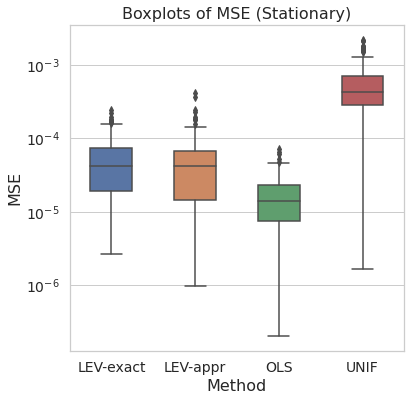

In [ ]:
data = pd.DataFrame({
    'LEV-exact': MSE_para_lev,
    'LEV-appr': MSE_para_fast,
    'OLS': MSE_para_OLS,
    'UNIF': MSE_para_random
})

sns.set(style="whitegrid")

plt.figure(figsize=(6, 6))
plt.yscale('log')

sns.boxplot(data=data, width=0.5)

plt.title("Boxplots of MSE (Stationary)", fontsize = 16)
plt.xlabel("Method", fontsize = 16)
plt.ylabel("MSE", fontsize = 16)
plt.tick_params(axis='both', labelsize=14)
plt.show()